In [95]:
import torch 
import torch.nn as nn
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torchsummary import summary


device = "cuda" if torch.cuda.is_available() else "cpu"

In [47]:
import numpy as np

In [8]:
device

'cuda'

# Performing upscaling via conv transpose 2d

In [2]:
m = nn.ConvTranspose2d(1,1,kernel_size=2, stride=2, padding=0)

In [3]:
inputs = torch.ones([1,1,3,3])

In [4]:
output = m(inputs)

In [6]:
output.shape  # clearly inverse of conv2d. The dimensions have increase 2x

torch.Size([1, 1, 6, 6])

# Semantic Segmentation with Unet

In [9]:
base_url = os.path.join("8","dataset1")

In [11]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [76]:
class SegData(Dataset):
    def __init__(self, split):
        self.split = split
        self.items = stems(os.path.join(base_url,f"images_prepped_{self.split}")) # will return all files in this folder
        
        #print(self.items)
        
    def __len__(self):
        return len(self.items)
    
    
    def __getitem__(self, ix):
        file_path = os.path.join(base_url,f"images_prepped_{self.split}",f"{self.items[ix]}.png")
        image  = read(file_path,1)
        # print(file_path)
        # show(image)
        image = cv2.resize(image, (224,224))
        
        
        mask_path = os.path.join(base_url,f"annotations_prepped_{self.split}",f"{self.items[ix]}.png")
        mask = read(mask_path) ## reading black and white
        mask = cv2.resize(mask, (224,224))
        return image, mask
    
    def choose(self):
        return self[randint(len(self))]
    
    
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))  # take the batch(image and mask), zip them together and create a list
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        
        return ims, ce_masks
        
        
           
    

In [77]:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)
     

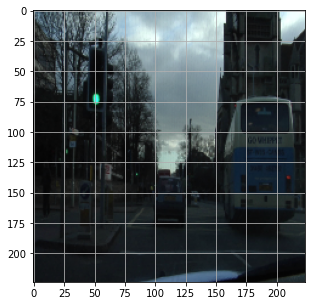

In [78]:
show(trn_ds[10][0], grid=True)

In [79]:
for i in trn_dl:
    print(i)
    break

(
    tensor[4, 3, 224, 224] n=602112 x∈[-2.101, 2.640] μ=-0.334 σ=1.301 cuda:0,
    tensor[4, 224, 224] i64 n=200704 x∈[0, 11] μ=2.828 σ=2.481 cuda:0
)

In [80]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [81]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, stride=2, kernel_size=2),
        nn.ReLU(inplace=True)
        ) 




In [82]:
from torchvision.models import vgg16_bn

In [83]:
enc = vgg16_bn(pretrained = True)

c:\Users\rachi\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rachi\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [85]:
enc.features[:6]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
)

In [92]:
nn.Sequential(*enc.features[6:13])

Sequential(
  (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
)

In [90]:
print(enc)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): ReLU(inplace=True)
    (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (19): ReLU(inplace=True)
    (20): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (21): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (22): ReLU(inplace=True)
    (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (24): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (25): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (26): ReLU(inplace=True)
    (27): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (28): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (29): ReLU(inplace=True)
    (30): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (31): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (32): ReLU(inplace=True)
    (33): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (35): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (36): ReLU(inplace=True)
    (37): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (38): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (39): ReLU(inplace=True)
    (40): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (41): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (42): ReLU(inplace=True)
    (43): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )
)

In [94]:
enc.features[34:]

Sequential(
  (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (35): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (36): ReLU(inplace=True)
  (37): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (38): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (39): ReLU(inplace=True)
  (40): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (41): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (42): ReLU(inplace=True)
  (43): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [97]:
print(summary(enc, torch.zeros((1,3,224,224))))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-3                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-4                       [-1, 64, 224, 224]        36,928
|    └─BatchNorm2d: 2-5                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-6                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-7                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       73,856
|    └─BatchNorm2d: 2-9                  [-1, 128, 112, 112]       256
|    └─ReLU: 2-10                        [-1, 128, 112, 112]       --
|    └─Conv2d: 2-11                      [-1, 128, 112, 112]       147,584
|    └─BatchNorm2d: 2-12                 [-1, 128, 112, 112]      

==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-3                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-4                       [-1, 64, 224, 224]        36,928
|    └─BatchNorm2d: 2-5                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-6                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-7                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       73,856
|    └─BatchNorm2d: 2-9                  [-1, 128, 112, 112]       256
|    └─ReLU: 2-10                        [-1, 128, 112, 112]       --
|    └─Conv2d: 2-11                      [-1, 128, 112, 112]       147,584
|    └─BatchNorm2d: 2-12                 [-1, 128, 112, 112]       256
|    └─ReLU: 2-13                        [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-14                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-15                      [-1, 256, 56, 56]         295,168
|    └─BatchNorm2d: 2-16                 [-1, 256, 56, 56]         512
|    └─ReLU: 2-17                        [-1, 256, 56, 56]         --
|    └─Conv2d: 2-18                      [-1, 256, 56, 56]         590,080
|    └─BatchNorm2d: 2-19                 [-1, 256, 56, 56]         512
|    └─ReLU: 2-20                        [-1, 256, 56, 56]         --
|    └─Conv2d: 2-21                      [-1, 256, 56, 56]         590,080
|    └─BatchNorm2d: 2-22                 [-1, 256, 56, 56]         512
|    └─ReLU: 2-23                        [-1, 256, 56, 56]         --
|    └─MaxPool2d: 2-24                   [-1, 256, 28, 28]         --
|    └─Conv2d: 2-25                      [-1, 512, 28, 28]         1,180,160
|    └─BatchNorm2d: 2-26                 [-1, 512, 28, 28]         1,024
|    └─ReLU: 2-27                        [-1, 512, 28, 28]         --
|    └─Conv2d: 2-28                      [-1, 512, 28, 28]         2,359,808
|    └─BatchNorm2d: 2-29                 [-1, 512, 28, 28]         1,024
|    └─ReLU: 2-30                        [-1, 512, 28, 28]         --
|    └─Conv2d: 2-31                      [-1, 512, 28, 28]         2,359,808
|    └─BatchNorm2d: 2-32                 [-1, 512, 28, 28]         1,024
|    └─ReLU: 2-33                        [-1, 512, 28, 28]         --
|    └─MaxPool2d: 2-34                   [-1, 512, 14, 14]         --
|    └─Conv2d: 2-35                      [-1, 512, 14, 14]         2,359,808
|    └─BatchNorm2d: 2-36                 [-1, 512, 14, 14]         1,024
|    └─ReLU: 2-37                        [-1, 512, 14, 14]         --
|    └─Conv2d: 2-38                      [-1, 512, 14, 14]         2,359,808
|    └─BatchNorm2d: 2-39                 [-1, 512, 14, 14]         1,024
|    └─ReLU: 2-40                        [-1, 512, 14, 14]         --
|    └─Conv2d: 2-41                      [-1, 512, 14, 14]         2,359,808
|    └─BatchNorm2d: 2-42                 [-1, 512, 14, 14]         1,024
|    └─ReLU: 2-43                        [-1, 512, 14, 14]         --
|    └─MaxPool2d: 2-44                   [-1, 512, 7, 7]           --
├─AdaptiveAvgPool2d: 1-2                 [-1, 512, 7, 7]           --
├─Sequential: 1-3                        [-1, 1000]                --
|    └─Linear: 2-45                      [-1, 4096]                102,764,544
|    └─ReLU: 2-46                        [-1, 4096]                --
|    └─Dropout: 2-47                     [-1, 4096]                --
|    └─Linear: 2-48                      [-1, 4096]                16,781,312
|    └─ReLU: 2-49                        [-1, 4096]       

In [98]:
class UNet(nn.Module):
    def __init__(self, pretrained = True, out_channels = 12):
        super().__init__()
        
        
        self.encoder = vgg16_bn(pretrained=True).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])
        
        
        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512,1024)
        
        
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512+512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
        
        
        
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        
        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)
        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x
        
        
        
        
        
        

In [99]:
ce = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc
    
    

In [100]:

def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [101]:

model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20
     

c:\Users\rachi\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rachi\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
log = Report(n_epochs)

In [104]:

for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000  val_acc: 0.842  trn_acc: 0.837  val_loss: 0.581  trn_loss: 0.700  (508.70s - 9665.34s remaining)
EPOCH: 2.000  val_acc: 0.872  trn_acc: 0.880  val_loss: 0.508  trn_loss: 0.459  (530.12s - 4771.06s remaining)
EPOCH: 3.000  val_acc: 0.886  trn_acc: 0.892  val_loss: 0.451  trn_loss: 0.397  (551.56s - 3125.52s remaining)
EPOCH: 4.000  val_acc: 0.857  trn_acc: 0.902  val_loss: 0.527  trn_loss: 0.355  (573.12s - 2292.48s remaining)
EPOCH: 5.000  val_acc: 0.863  trn_acc: 0.908  val_loss: 0.516  trn_loss: 0.331  (594.66s - 1783.97s remaining)
EPOCH: 6.000  val_acc: 0.881  trn_acc: 0.911  val_loss: 0.441  trn_loss: 0.314  (616.20s - 1437.79s remaining)
EPOCH: 7.000  val_acc: 0.878  trn_acc: 0.917  val_loss: 0.426  trn_loss: 0.291  (637.73s - 1184.35s remaining)
EPOCH: 8.000  val_acc: 0.834  trn_acc: 0.921  val_loss: 0.574  trn_loss: 0.274  (659.35s - 989.02s remaining)
EPOCH: 9.000  val_acc: 0.885  trn_acc: 0.923  val_loss: 0.413  trn_loss: 0.265  (681.04s - 832.39s remaining)
EPO

100%|██████████| 121/121 [00:00<00:00, 257.47it/s]


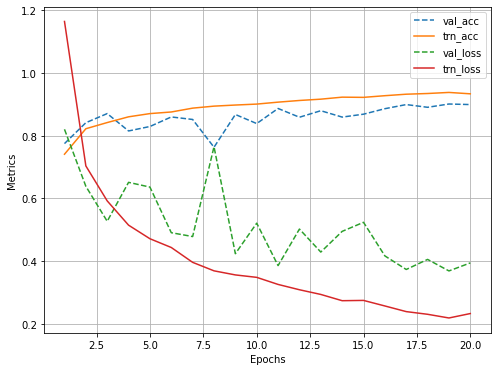

In [105]:
log.plot_epochs()

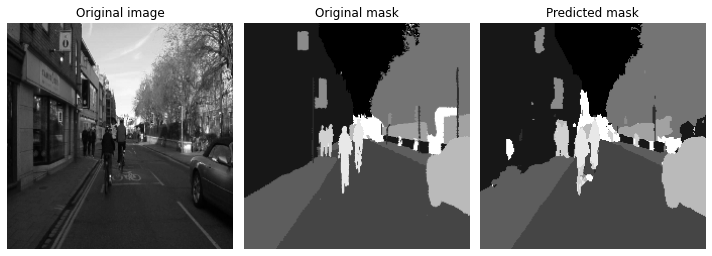

In [110]:

im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'],figsize=(10))

### Inference for new image

In [171]:
files = os.listdir("8\\dataset1\\images_prepped_test")

In [182]:
index = np.random.choice(len(files))

In [183]:
img_url = os.path.join("8\\dataset1\\images_prepped_test", files[index])

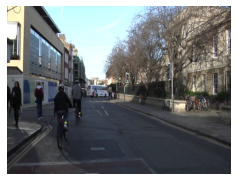

In [184]:
show(read(img_url,1), sz=(4))

In [192]:
img = read(img_url,1)

In [193]:
img = cv2.resize(img, (224,224))

In [194]:
img = tfms(img/255.).float().to(device)

In [195]:
_, _mask = torch.max(_mask, dim=1)

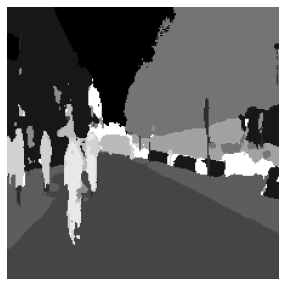

In [196]:
show(_mask.permute(1,2,0).squeeze())

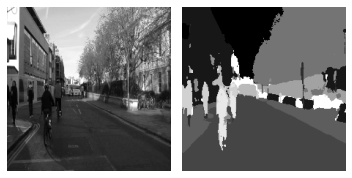

In [197]:
subplots([img[0],_mask.permute(1,2,0).squeeze()])